## Ensemble Learning

* 여러 개의 Classifier를 생성하고 그 예측을 결합하여 보다 정확한 최종 예측을 도출하는 기법
* 단일 모델의 약점을 다수의 모델을 결합하여 보완
* 뛰어난 성능을 가진 모델들로만 구성하는 것보다 성능이 떨어지더라도 서로 다른 유형의 모델을 섞는 것이 전체 성능이 더 우수할 수 있음
* Ensemble 유형
  * Voting
    * 일반적으로 서로 다른 알고리즘을 가진 Classifier들을 결합하여 같은 Data Set으로 Classifier별 성능을 비교
    * Voting의 유형
      * Hard Voting
        * 다수의 classifier 간 다수결로 최종 class를 결정
      * Soft Voting
        * 다수의 calssifier들의 class 확률을 평균하여 결정
        * Hard Voting보다 예측 성능이 우수함
  * Bagging (Bootstrap aggregating)
    * 각각의 Classifier는 같은 유형의 알고리즘이지만 Sampling Data를 다르게하여 학습을 수행하여 성능을 비교
    * Random Forest
        * 여러 개의 결정 트리 분류기가 전체 데이터에서 Bagging 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 Voting을 통해 예측 결정을 함
        * max_features의 'None' 값이 전체 Features의 개수가 아닌 sqrt과 같음 (column이 9개라면, 3)
  * Boosting
    * 에이다 부스팅
    * 그래디언트 부스팅
    * XGBoost
    * LightGBM

### Voting Classifier
**위스콘신 유방암 데이터 load**

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


**VotingClassifier로 LogisticRegression과 KNN을 Voting 방식으로 결합하고 성능 비교**

In [2]:
# 개별 모델은 LogisticRegression과 KNN
lr_clf = LogisticRegression(max_iter=3000)
knn_clf = KNeighborsClassifier(n_neighbors = 8)

# 개별 모델을 Soft Voting 기반의 Ensemble 모델로 구현한 분류기
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9649
KNeighborsClassifier 정확도: 0.9386


### Random Forest
<br />

**원본 데이터에 중복된 Feature 명으로 인하여 신규 버전의 Pandas에서 Duplicate name 에러를 발생.** 

**중복 feature명에 대해서 원본 feature 명에 '_1(또는2)'를 추가로 부여하는 함수인 get_new_feature_name_df() 생성**

In [3]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [4]:
def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

**학습/테스트 데이터로 분리하고 랜덤 포레스트로 학습/예측/평가**

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


**GridSearchCV로 교차검증 및 하이퍼 파라미터 튜닝**

In [6]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [8, 12, 18],
    'min_samples_split': [8, 16, 20]
}

# n_jobs = -1, 전체 CPU의 call을 모두 활용
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미더: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미더: 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


**튜닝된 하이퍼 파라미터로 재학습 및 예측/평가**

In [7]:
rf_clf1 = RandomForestClassifier(n_estimators = 300, max_depth = 10, min_samples_leaf = 8, min_samples_split =  8, random_state = 0)

rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9165


**개별 feature들의 중요도 시각화**

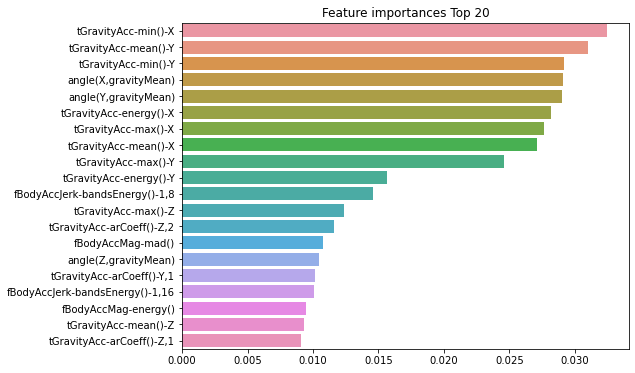

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()